# Obtención de las imágenes provenientes de Sentinel-2

## Imports

In [2]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Point

import planetary_computer as pc
from pystac_client import Client
import geopy.distance as distance
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

import os
import json
import pickle

%matplotlib inline

## Definición de parámetros

In [5]:
DATA_DIR = Path.cwd().resolve() / "data"
SENTINEL_DATA_DIR = DATA_DIR / "sentinel"

## Metadata in situ

In [7]:
metadata = pd.read_csv(DATA_DIR / "metadata.csv")

In [8]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

In [9]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)

## Funciones

In [10]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

In [11]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%dT"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}00:00:00Z/{pd.to_datetime(date).strftime(datetime_format)}23:59:59Z"

    return date_range

In [12]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    # true color image. 10 m resolution
    visual_img = (
        rioxarray.open_rasterio(pc.sign(item.assets["visual"].href))
        .rio.clip_box(
            minx=minx,
            miny=miny,
            maxx=maxx,
            maxy=maxy,
            crs="EPSG:4326",
        )
        .to_numpy()
    )

    # scene classification image. 20 m resolution
    SCL_img = (
        rioxarray.open_rasterio(pc.sign(item.assets["SCL"].href))
        .rio.clip_box(
            minx=minx,
            miny=miny,
            maxx=maxx,
            maxy=maxy,
            crs="EPSG:4326",
        )
        .to_numpy()
    )
    # 560 nm band. 10 m resolution
    b03_img = (
        rioxarray.open_rasterio(pc.sign(item.assets["B03"].href))
        .rio.clip_box(
            minx=minx,
            miny=miny,
            maxx=maxx,
            maxy=maxy,
            crs="EPSG:4326",
        )
        .to_numpy()
    )
    # 665 nm band. 10 m resolution
    b04_img = (
        rioxarray.open_rasterio(pc.sign(item.assets["B04"].href))
        .rio.clip_box(
            minx=minx,
            miny=miny,
            maxx=maxx,
            maxy=maxy,
            crs="EPSG:4326",
        )
        .to_numpy()
    )
    # 704 nm band. 20 m resolution
    b05_img = (
        rioxarray.open_rasterio(pc.sign(item.assets["B05"].href))
        .rio.clip_box(
            minx=minx,
            miny=miny,
            maxx=maxx,
            maxy=maxy,
            crs="EPSG:4326",
        )
        .to_numpy()
    )


    return [visual_img, b03_img, b04_img, b05_img, SCL_img]

In [14]:
def select_best_item_list(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
                "cloud_cover": item.properties["eo:cloud_cover"],
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # return the closest imagery by time
    return item_details.sort_values(by="time_diff", ascending=True)

In [18]:
def check_clouds(ordered_items, bounding_box):
    """ """
    (minx, miny, maxx, maxy) = bounding_box
    best_item = None

    for i in range(len(ordered_items)):
        cloud_image_array = (
            rioxarray.open_rasterio(
                pc.sign(ordered_items.iloc[i].item_obj.assets["SCL"].href)
            )
            .rio.clip_box(
                minx=minx,
                miny=miny,
                maxx=maxx,
                maxy=maxy,
                crs="EPSG:4326",
            )
            .to_numpy()
        )
        # 0 - No data
        # 1 - Saturated / Defective
        # 2 - Dark Area Pixels
        # 3 - Cloud Shadows
        # 4 - Vegetation
        # 5 - Bare Soils
        # 6 - Water
        # 7 - Clouds low probability / Unclassified
        # 8 - Clouds medium probability
        # 9 - Clouds high probability
        # 10 - Cirrus
        # 11 - Snow / Ice

        if np.size(
            cloud_image_array[
                (cloud_image_array != 0)
                & (cloud_image_array != 1)
                & (cloud_image_array != 2)
                & (cloud_image_array != 3)
                & (cloud_image_array != 8)
                & (cloud_image_array != 9)
                & (cloud_image_array != 10)
            ]
        ) >= 0.25 * np.size(cloud_image_array):
            best_item = ordered_items.iloc[i]
            break

    return best_item

## Extracción de las imágenes

In [16]:
# Establish a connection to the STAC API
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [17]:
train_subset = metadata

La siguiente celda conviene ejecutarla más de una vez en caso de que el pull falle por la conexión con la API

In [23]:
# save outputs in dictionaries
selected_items = {}
not_possible = []
errored_ids = []

for row in tqdm(train_subset.itertuples(), total=len(train_subset)):
    pass
    # check if we've already saved the selected image array
    image_array_pth = SENTINEL_DATA_DIR / f"visual/{row.uid}.npy"

    try:
        with open(image_array_pth, "rb") as f:
            continue

    # search and load the image array if not
    except:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a"],
                bbox=search_bbox,
                datetime=date_range,
                query={
                    "platform": {
                        "in": [
                            "Sentinel-2A",
                            "Sentinel-2B",
                        ]
                    }
                },
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                not_possible.append(row.uid)
                pass
            else:
                ordered_items = select_best_item_list(
                    items, row.date, row.latitude, row.longitude
                )

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=200
            )

            # comprobación nubosidad
            best_item = check_clouds(ordered_items, feature_bbox)
            if best_item is None:
                not_possible.append(row.uid)
                continue

            # add to dictionary tracking best items
            selected_items[row.uid] = {
                "item_object": str(best_item["item_obj"]),
                "item_platform": best_item["platform"],
                "item_date": best_item["datetime"],
                "cloud_properties": best_item["cloud_cover"],
                "time_diff": str(best_item["time_diff"]),
            }

            # crop the image and mask with SCL. Get bands 3,4 and 5; and SCL
            [
                image_array,
                b03_image_array,
                b04_image_array,
                b05_image_array,
                scl_image_array,
            ] = crop_sentinel_image(best_item["item_obj"], feature_bbox)

            # save image array so we don't have to rerun
            with open(SENTINEL_DATA_DIR / f"visual/{row.uid}.npy", "wb") as f:
                np.save(f, image_array)
            with open(SENTINEL_DATA_DIR / f"b03/{row.uid}.npy", "wb") as f:
                np.save(f, b03_image_array)
            with open(SENTINEL_DATA_DIR / f"b04/{row.uid}.npy", "wb") as f:
                np.save(f, b04_image_array)
            with open(SENTINEL_DATA_DIR / f"b05/{row.uid}.npy", "wb") as f:
                np.save(f, b05_image_array)
            with open(SENTINEL_DATA_DIR / f"scl/{row.uid}.npy", "wb") as f:
                np.save(f, scl_image_array)

        # keep track of any that ran into errors without interrupting the process
        except Exception as e:
            errored_ids.append(row.uid)

100%|██████████| 23570/23570 [8:58:50<00:00,  1.37s/it]   


In [24]:
with open(SENTINEL_DATA_DIR / "selected_items.txt", "w") as f:
    json.dump(selected_items, f)

In [25]:
print(f"Could not pull satellite imagery for {len(errored_ids)} samples")

Could not pull satellite imagery for 6593 samples


Vista de imagenes extraídas

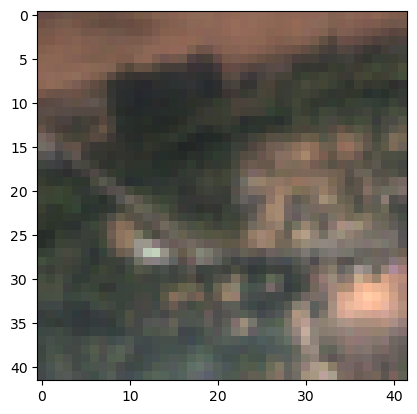

In [12]:
with open(SENTINEL_DATA_DIR / f"visual/ozir.npy", "rb") as f:
    image_array = np.load(f)
plt.imshow(np.transpose(image_array, axes=[1, 2, 0]))